In [1]:
import os
print(os.listdir("F:\Skin_data\data_skintone"))


['dark', 'light', 'mid-dark', 'mid-light']


In [19]:
import os

images = []
classes = []

base_path = "F:\Skin_data\data_skintone"

for fold in os.listdir(base_path):
    path = os.path.join(base_path, fold)
    if os.path.isdir(path):  # ✅ Only process if it's a directory
        print(fold, len(os.listdir(path)))
        images.append(os.path.join(path, os.listdir(path)[0]))
        classes.append(fold)
source_base ="F:\Skin_data\data_skintone"
dest_base = "F:\\gd"

dark 8634
light 9769
mid-dark 10576
mid-light 6844


In [13]:
import os
import cv2
import shutil
from tqdm import tqdm
import mediapipe as mp

# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# Define your source and destination base folders
source_base = "F:\Skin_data\data_skintone"  # Use raw string or double backslashes
dest_base = "F:\gd"

def is_frontal_with_two_eyes(landmarks, width, height):
    # Your custom logic to detect frontal face with both eyes visible
    return True  # Placeholder

for skintone in os.listdir(source_base):
    if skintone.startswith('.') or skintone.lower() == "thumbs.db":
        continue

    src_folder = os.path.join(source_base, skintone)
    if not os.path.isdir(src_folder):
        continue

    dst_folder = os.path.join(dest_base, skintone)
    os.makedirs(dst_folder, exist_ok=True)

    valid_count = 0
    print(f"Processing {skintone}...")

    for img_name in tqdm(os.listdir(src_folder)):
        if valid_count >= 1000:
            break

        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(src_folder, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            result = face_mesh.process(img_rgb)

            if result.multi_face_landmarks:
                landmarks = result.multi_face_landmarks[0].landmark
                h, w = img.shape[:2]

                if is_frontal_with_two_eyes(landmarks, w, h):
                    shutil.copy(img_path, os.path.join(dst_folder, img_name))
                    valid_count += 1

    print(f"✓ {valid_count} valid images saved for {skintone}\n")


Processing dark...


 13%|█▎        | 1092/8634 [00:26<03:03, 41.04it/s]


✓ 1000 valid images saved for dark

Processing light...


 11%|█         | 1039/9769 [00:24<03:26, 42.31it/s]


✓ 1000 valid images saved for light

Processing mid-dark...


 10%|█         | 1097/10576 [00:24<03:35, 44.02it/s]


✓ 1000 valid images saved for mid-dark

Processing mid-light...


 16%|█▌        | 1077/6844 [00:21<01:54, 50.31it/s]

✓ 1000 valid images saved for mid-light


In [14]:
import os

images = []
classes = []

base_path = "F:\gd"

for fold in os.listdir(base_path):
    path = os.path.join(base_path, fold)
    if os.path.isdir(path):  # ✅ Only process if it's a directory
        files = os.listdir(path)
        if len(files) == 0:
            print(f"{fold} is empty.")
            continue
        print(f"{fold} {len(files)}")
        images.append(os.path.join(path, files[0]))
        classes.append(fold)


dark 1000
light 1000
mid-dark 1000
mid-light 1000


In [23]:
from sklearn.model_selection import train_test_split  # ✅ Add this
all_paths = []
all_labels = []
categories = os.listdir(dest_base)
for category in categories:
    folder = os.path.join(dest_base, category)
    for img in os.listdir(folder):
        all_paths.append(os.path.join(folder, img))
        all_labels.append(category)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

train_dir = os.path.join(dest_base, "train")
valid_dir = os.path.join(dest_base, "val")

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, category), exist_ok=True)

for img, label in zip(train_paths, train_labels):
    shutil.copy(img, os.path.join(train_dir, label, os.path.basename(img)))

for img, label in zip(val_paths, val_labels):
    shutil.copy(img, os.path.join(valid_dir, label, os.path.basename(img)))

print("Dataset has been successfully renamed and reorganized!")



Dataset has been successfully renamed and reorganized!


NameError: name 'ImageDataGenerator' is not defined

In [21]:
print(f"Total images found: {len(all_paths)}")


Total images found: 0


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 3: Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=categories
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=categories
)

print(f"Class indices: {train_generator.class_indices}")



Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Class indices: {'dark': 0, 'light': 1, 'mid-dark': 2, 'mid-light': 3}


In [35]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)  # 4 classes (dark, light, mid-dark, mid-light)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 930ms/step - accuracy: 0.4849 - loss: 1.4014 - val_accuracy: 0.6212 - val_loss: 0.8467
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 869ms/step - accuracy: 0.6534 - loss: 0.7659 - val_accuracy: 0.6438 - val_loss: 0.8051
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 851ms/step - accuracy: 0.6778 - loss: 0.7430 - val_accuracy: 0.6550 - val_loss: 0.7903
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 867ms/step - accuracy: 0.7046 - loss: 0.6696 - val_accuracy: 0.6850 - val_loss: 0.7616
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 867ms/step - accuracy: 0.7101 - loss: 0.6658 - val_accuracy: 0.6963 - val_loss: 0.7027
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 870ms/step - accuracy: 0.7141 - loss: 0.6606 - val_accuracy: 0.6888 - val_loss: 0.7282
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 885ms/step - accuracy: 0.7319 - loss: 0.6217 - val_accuracy: 0.6975 - val_loss: 0.7371
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 873ms/step - accuracy: 0.7373 - loss: 0

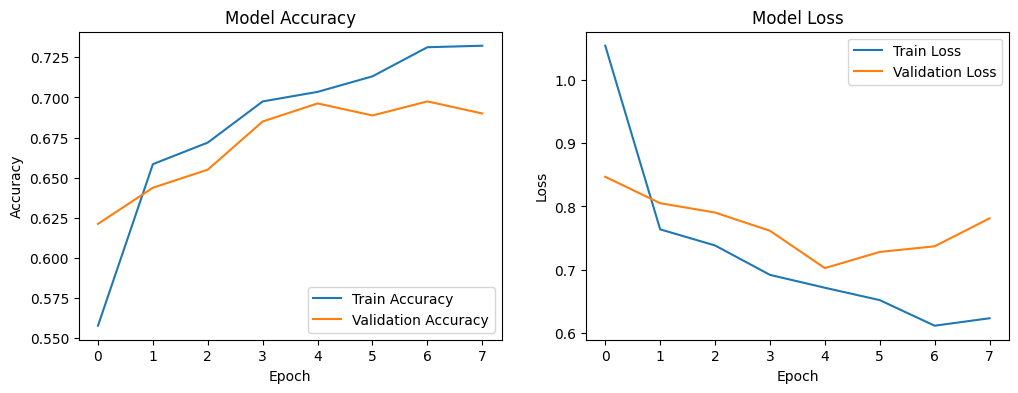

In [37]:

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


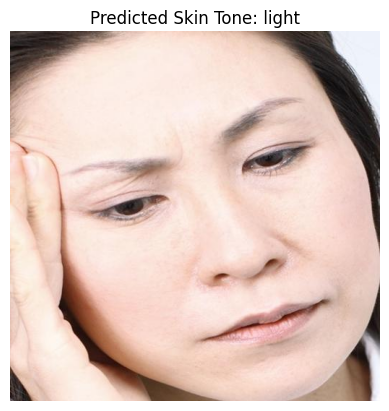

Predicted Skin Tone Class: light


In [42]:
from tensorflow.keras.preprocessing import image
import numpy as np
img_path = "1430627.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

plt.imshow(image.load_img(img_path))
plt.title(f'Predicted Skin Tone: {categories[predicted_class]}')
plt.axis('off')
plt.show()

print(f'Predicted Skin Tone Class: {categories[predicted_class]}')